# 2) Neural Network LM

A neural network language model (consult *A Neural Probabilistic Language Model* http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [0]:
!pip install -q torchtext 

import torch
import torchtext
from torchtext.vocab import Vectors
from torchtext.data.iterator import BPTTIterator
from torchtext.data import Batch, Dataset
import math


import numpy as np

from tqdm import tqdm_notebook
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim


In [0]:
# Our input $x$
TEXT = torchtext.data.Field()

!curl -qO https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW2/input.txt
!curl -qO https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW2/train.5k.txt
!curl -qO https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW2/train.txt
!curl -qO https://raw.githubusercontent.com/harvard-ml-courses/cs287-s18/master/HW2/valid.txt
!curl -qO https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb.test.txt



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  185k  100  185k    0     0  32554      0  0:00:05  0:00:05 --:--:-- 43950
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  595k  100  595k    0     0  1317k      0 --:--:-- --:--:-- --:--:-- 1314k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4982k  100 4982k    0     0  7262k      0 --:--:-- --:--:-- --:--:-- 7262k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  390k  100  390k    0     0  1201k      0 --:--:-- --:--:-- --:--:-- 1197k
  % Total    % Received % Xferd  Average Speed   Tim

In [0]:
# Data distributed with the assignment
train, val, test = torchtext.datasets.LanguageModelingDataset.splits(
    path=".", 
    train="train.txt", validation="valid.txt", test="ptb.test.txt", text_field=TEXT)

train_iter, val_iter, test_iter = BPTTIterator.splits(
    (train, val, test), batch_size=10, device=torch.device("cuda"), bptt_len=32, repeat=False)

TEXT.build_vocab(train) #for whole vocab
# TEXT.build_vocab(train, max_size=1000) #for debugging
url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec'
TEXT.vocab.load_vectors(vectors=Vectors('wiki.simple.vec', url=url))

.vector_cache/wiki.simple.vec: 293MB [00:24, 12.0MB/s]                           
 99%|█████████▉| 110039/111051 [00:10<00:00, 10246.75it/s]

In [0]:
class NeuralLM(nn.Module):
  def __init__(self, embed_size, V, ngram_size, hidden_size):
    super(NeuralLM, self).__init__()
    self.embeddings = nn.Embedding(V, embed_size)
    self.hidden = nn.Linear(embed_size*(ngram_size-1), hidden_size, bias=True) #Hx + d
    self.hidden2 = nn.Linear(hidden_size, V, bias=True) #U(tanh(Hx + d)) + b
    self.direct = nn.Linear(embed_size*(ngram_size-1), V, bias=False) #Wx

  def forward(self, x):
    embeds = self.embeddings(x)
    embeds = embeds.view(len(embeds), -1)
    output = torch.tanh(self.hidden(embeds))
    output = self.hidden2(output) + self.direct(embeds)
    # output = self.hidden2(output)
    return F.log_softmax(output, dim=1)

class NeuralLMPretrained(nn.Module):
  def __init__(self, embed_size, V, ngram_size, hidden_size, TEXT):
    super(NeuralLMPretrained, self).__init__()
    _, embed_size = TEXT.vocab.vectors.shape
    self.embeddings = nn.Embedding(V, embed_size)
    self.embeddings.weight.data.copy_(TEXT.vocab.vectors)

    self.hidden = nn.Linear(embed_size*(ngram_size-1), hidden_size, bias=True) #Hx + d
    self.hidden2 = nn.Linear(hidden_size, V, bias=True) #U(tanh(Hx + d)) + b
    self.direct = nn.Linear(embed_size*(ngram_size-1), V, bias=False) #Wx

  def forward(self, x):
    embeds = self.embeddings(x)
    embeds = embeds.view(len(embeds), -1)
    output = torch.tanh(self.hidden(embeds))
    output = self.hidden2(output) + self.direct(embeds)
    return F.log_softmax(output, dim=1)

class NeuralLMTrainer:
  def __init__(self, train_iter, val_iter, ngram_size):
    self.train_iter = train_iter
    self.val_iter = val_iter
    self.ngram_size = ngram_size
  
  def format_data(self, batch, sample=False):
    if not sample: #then it's a batch
      x = list()
      for example_idx in range(batch.text.data.size()[1]):
        x.extend(batch.text.data[:, example_idx].tolist())
    else: #then it's a single sample
      x = batch
    grams = [tuple(x[i : i + self.ngram_size]) for i in range(len(x) - self.ngram_size + 1)]
    x_out = Variable(torch.LongTensor([gram[:-1] for gram in grams]))
    y_out = Variable(torch.LongTensor([gram[-1] for gram in grams]))
    if torch.cuda.is_available():
      return x_out.cuda(), y_out.cuda()
    else:
      return x_out, y_out
  
  def train(self, model, epochs, lr):
    loss_function = nn.NLLLoss(reduction="mean") #use negative log likelihood as the loss function, get ppl for free
    params = filter(lambda x: x.requires_grad, model.parameters())
    optimizer = optim.Adam(params=params, lr=lr)

    train_ppls = list()
    val_ppls = list()
    for epoch in tqdm_notebook(range(epochs)):
      model.train()
      epoch_losses = list()
      for batch in tqdm_notebook(self.train_iter):
        x, y = self.format_data(batch)
        optimizer.zero_grad()
        logits = model(x)
        # print('logits: ', logits)
        loss = loss_function(logits, y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

      # Get val acc at every epoch
      model.eval()
      train_ppl = np.exp(np.mean(epoch_losses))
      val_ppl = self.validate(model)
      print('Epoch={}\ttrain_ppl={}\tval_ppl={}\tloss={}'.format(epoch, train_ppl, val_ppl, np.mean(epoch_losses)))
      train_ppls.append(train_ppl)
      val_ppls.append(val_ppl)
    
    return train_ppls, val_ppls
  
  def validate(self, model):
    loss_function = nn.NLLLoss(reduction="mean")
    losses = list()
    for batch in tqdm_notebook(self.val_iter):
      x, y = self.format_data(batch)
      logits = model(x)
      loss = loss_function(logits, y)
      losses.append(loss.item())
    pp_val = np.exp(np.mean(losses))
    return pp_val

In [0]:
def get_test_pp(model, test_iter, trainer):
  with torch.no_grad():
    loss_function = nn.NLLLoss()
    losses = list()
    for batch in tqdm_notebook(test_iter, position=0, leave=True):
      x, y = trainer.format_data(batch)
      yhat = model(x)
      loss = loss_function(yhat, y)
      losses.append(loss.item())
    pp_test = np.exp(np.mean(losses))
    return pp_test, losses

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
V = len(TEXT.vocab)
embed_size = 300
ngram_size = 3
# hidden_size = round(((embed_size*(ngram_size-1)) + V) / 2) #mean of input and output
hidden_size = 1024
print("vocab of len={}".format(V))

vocab of len=10001


In [0]:
# Train
lr = 1e-5
epochs = 5

In [0]:
naive_model = NeuralLM(embed_size, V, ngram_size, hidden_size)
naive_model.to(device)

NeuralLM(
  (embeddings): Embedding(10001, 300)
  (hidden): Linear(in_features=600, out_features=1024, bias=True)
  (hidden2): Linear(in_features=1024, out_features=10001, bias=True)
  (direct): Linear(in_features=600, out_features=10001, bias=False)
)

In [0]:
naive_trainer = NeuralLMTrainer(train_iter, val_iter, ngram_size)
naive_train_ppls, naive_val_ppls = naive_trainer.train(naive_model, epochs, lr)

PATH = './naive_nn.pkl'
torch.save(naive_model.state_dict(), PATH)

Epoch=0	train_ppl=2876.3778297816702	val_ppl=1234.194107963297	loss=7.964287083571626


Epoch=1	train_ppl=920.8476343325453	val_ppl=750.6817474826561	loss=6.8252945875341835


Epoch=2	train_ppl=623.1558701256821	val_ppl=573.710752397385	loss=6.434796680312559


Epoch=3	train_ppl=482.2288822142923	val_ppl=477.16095768565515	loss=6.178418860706323


Epoch=4	train_ppl=397.15505746802484	val_ppl=415.04232516769474	loss=5.9843267774007405



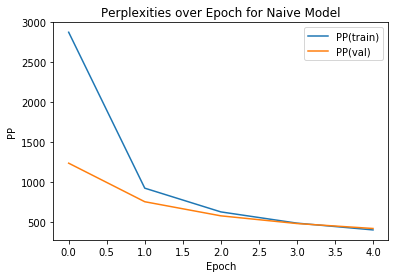

In [0]:
plt.plot(naive_train_ppls, label="PP(train)")
plt.plot(naive_val_ppls, label="PP(val)")
plt.title('Perplexities over Epoch for Naive Model')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('PP')
plt.show()

In [0]:
test_pp, test_losses = get_test_pp(naive_model, test_iter, naive_trainer)
print('naive model test pp: {}'.format(test_pp))


naive model test pp: 388.54443068571015


In [0]:
pretrained_model = NeuralLMPretrained(embed_size, V, ngram_size, hidden_size, TEXT)
pretrained_model.to(device)

NeuralLMPretrained(
  (embeddings): Embedding(10001, 300)
  (hidden): Linear(in_features=600, out_features=1024, bias=True)
  (hidden2): Linear(in_features=1024, out_features=10001, bias=True)
  (direct): Linear(in_features=600, out_features=10001, bias=False)
)

 99%|█████████▉| 110039/111051 [00:30<00:00, 10246.75it/s]

Epoch=0	train_ppl=1215.1184860819212	val_ppl=657.1977813674146	loss=7.102596870428929


Epoch=1	train_ppl=583.5794678735444	val_ppl=520.9644459777762	loss=6.369180634181799


Epoch=2	train_ppl=473.95723420908917	val_ppl=441.0771062796249	loss=6.161117094437144


Epoch=3	train_ppl=406.00058500883074	val_ppl=388.7448705715543	loss=6.006354600509145


Epoch=4	train_ppl=358.80907235495164	val_ppl=351.5684347251844	loss=5.882790415135185



Exception ignored in: <bound method tqdm.__del__ of  99%|█████████▉| 110039/111051 [04:40<00:00, 10246.75it/s]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 931, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py", line 52, in exit
    self.join()
  File "/usr/lib/python3.6/threading.py", line 1053, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


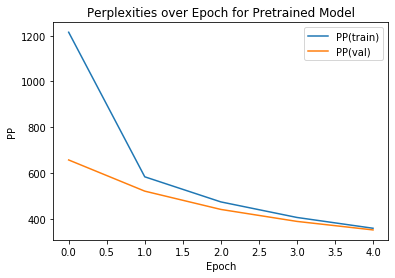

In [0]:
pretrained_trainer = NeuralLMTrainer(train_iter, val_iter, ngram_size)
pretrained_train_ppls, pretrained_val_ppls = pretrained_trainer.train(pretrained_model, epochs, lr)
PATH = './pretrained_nn.pkl'
torch.save(pretrained_model.state_dict(), PATH)

plt.plot(pretrained_train_ppls, label="PP(train)")
plt.plot(pretrained_val_ppls, label="PP(val)")
plt.title('Perplexities over Epoch for Pretrained Model')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('PP')
plt.show()

In [0]:
pretrained_pp, pretrained_losses = get_test_pp(pretrained_model, test_iter, pretrained_trainer)
print('pretrained model test pp: {}'.format(pretrained_pp))


pretrained model test pp: 328.2102467834442


In [0]:
def get_H(context, model, trainer):
  with torch.no_grad():
    loss_function = nn.NLLLoss()
    x, y = trainer.format_data(context, sample=False)
    yhat = model(x)
    H = loss_function(yhat, y)
    return H

In [0]:
examples = list()
for i, batch in enumerate(train_iter):
  if i in [1, 7]:
    examples.append(batch)
for i, batch in enumerate(test_iter):
  if i in [117, 231]:
    examples.append(batch)

In [0]:
entropies = list()
for context in examples:
  H = get_H(context, pretrained_model, pretrained_trainer)
  entropies.append(H.item())
entropies

[6.071245193481445, 5.684966564178467, 5.688162326812744, 5.4792633056640625]